<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/DNNs/Cuda%20Support/MINIST%20Classification%20Dash/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

## Load Data

In [2]:
trainset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 20
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

## Batch Visulaization

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([20, 1, 28, 28])
torch.Size([1, 28, 28])
0


In [5]:
numpy_images = images.numpy()
print(numpy_images.shape)
print(numpy_images[0].shape)
print(np.squeeze(numpy_images[0]).shape)

(20, 1, 28, 28)
(1, 28, 28)
(28, 28)


In [6]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

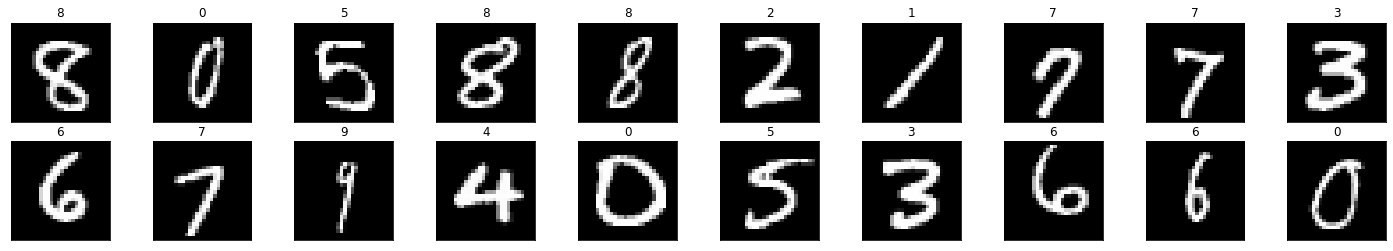

In [7]:
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
  image = np.squeeze(numpy_images[i])
  title = labels[i].item()
  ax = fig.add_subplot(2, 10, i+1, xticks=[],yticks=[])
  ax.imshow(image, cmap='gray')
  ax.set_title(str(title))

## Single Image Visualization

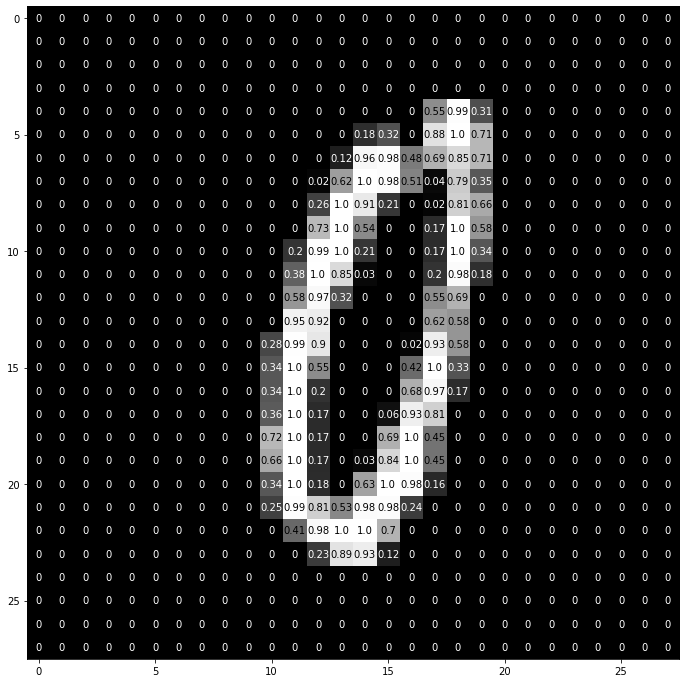

In [8]:
img = np.squeeze(numpy_images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## GPU Configure

In [9]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')

1
Tesla T4


## MNIST Model Class

In [10]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

In [11]:
class Mnist(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(784, 512), 
        nn.SELU(), 
        nn.Linear(512, 512), 
        nn.SELU(),
        nn.Linear(512, 10),
        nn.Softmax()
    )

  def predict(self, X):
    X = X.view(-1, 28 * 28)
    return self.net(X)
  
  def evaluation(self,dataloader):
    total, correct = 0, 0
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(gpu), labels.to(gpu)
      outputs = self.predict(inputs)
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()
    return correct / total
  
  def fit(self,epochs,trainloader,testloader):
    loss_arr = []
    loss_epoch_arr = []
    train_acc_arr =  []
    test_acc_arr = []
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.SGD(self.parameters(), lr=0.05)
    for epoch in range(epochs):
      self.train()
      for i, data in enumerate(trainloader, 0): 
        inputs, labels = data
        inputs, labels = inputs.to(gpu), labels.to(gpu)
        
        #clears the gradients of all optimized variables
        opt.zero_grad() 
        
        # Forward Pass
        outputs = self.predict(inputs) 
        
        # compute Loss
        loss = loss_fn(outputs, labels) 
        loss_arr.append(loss.item())
        
        #Compute gradient with respect to loss of weights 
        loss.backward() 
        
        # parameter updates
        opt.step()
      
      self.eval()
      # compute accuracy
      train_accuracy = self.evaluation(trainloader)
      train_acc_arr.append(train_accuracy)
      test_accuracy = self.evaluation(testloader)
      test_acc_arr.append(test_accuracy)
      loss_epoch = loss_arr[epoch]
      loss_epoch_arr.append(loss_epoch)
    plt.plot(loss_epoch_arr, 'r-')
    plt.plot(train_acc_arr, 'g-')
    plt.plot(test_acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


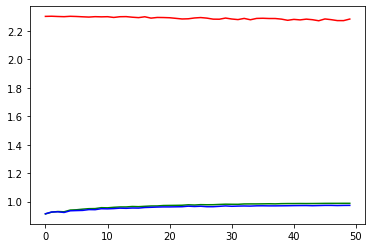

Loss before training 2.3021678924560547
Loss after training 1.4613621234893799
CPU times: user 13min 7s, sys: 11 s, total: 13min 18s
Wall time: 13min 27s


In [12]:
%%time
model = Mnist()
model = model.to(gpu)
model.fit(50,trainloader,testloader)

In [13]:
print("Train Accuracy is : ", model.evaluation(trainloader))
print("Test Accuracy is : ", model.evaluation(testloader))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Accuracy is :  0.98765
Test Accuracy is :  0.9732


## Test Batch Visulaization

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


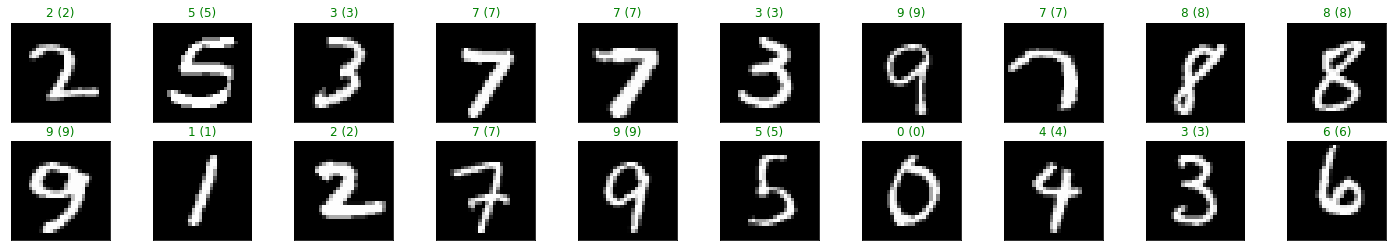

In [17]:
#obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model.predict(images.to(gpu))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))
